<a href="https://colab.research.google.com/github/sivahariditty/CNN-Experiments/blob/main/BatchNorm_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outline

1. Load dataset and visualise
2. Add batchnorm layers
3. Comparison with and without batchnorm layers
4. Add dropout layer
5. Comparison with and without dropout layer

In [88]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns


## Dataset and visualisation

In [89]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

In [90]:
type(trainset)

torchvision.datasets.mnist.MNIST

In [91]:
batch_size = 4

In [92]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [93]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
0


In [94]:
def imshow(img, title):
    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [95]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

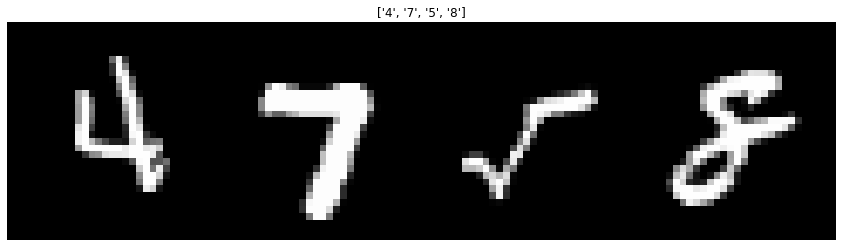

In [96]:
images, labels = show_batch_images(trainloader)

## Batchnorm

In [97]:
class MyNet(nn.Module):
    def __init__(self): 
        super(MyNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [98]:
class MyNetBN(nn.Module):
    def __init__(self): 
        super(MyNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [99]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [100]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [101]:
batch_size = 512

In [102]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [103]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

In [ ]:
loss_arr = []
loss_bn_arr = []

max_epochs = 2

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        if i % 10 == 0:
        
            inputs = inputs.view(inputs.size(0), -1)
            
            model.eval()
            model_bn.eval()
            
            a = model.classifier[0](inputs)
#             a = model.classifier[1](a)
#             a = model.classifier[2](a)
            a = a.detach().numpy().ravel()
            sns.distplot(a, kde=True, color='r', label='Normal') 
            
            b = model_bn.classifier[0](inputs)
            b = model_bn.classifier[1](b)
#             b = model_bn.classifier[2](b)
#             b = model_bn.classifier[3](b)
#             b = model_bn.classifier[4](b)
            b = b.detach().numpy().ravel()
            
            sns.distplot(b, kde=True, color='g', label='BatchNorm') 
            plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
            plt.legend()
            plt.show()
            plt.pause(0.5)
            
            model.train()
            model_bn.train()
        
        
    print('----------------------')

    plt.plot(loss_arr, 'r', label='Normal')
    plt.plot(loss_bn_arr, 'g', label='BatchNorm')
    plt.legend()
    plt.show()

In [128]:
class CNN_BN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 3, 5),         # (N, 1, 28, 28) -> (N,  3, 24, 24)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 3, 24, 24) -> (N,  3, 12, 12)
            nn.Conv2d(3, 6, 3),
            nn.BatchNorm2d(6)           # (N, 3, 12, 12) -> (N,  6, 10, 10) 
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N, 6, 10, 10) -> (N,  6, 5, 5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(150, 25),         # (N, 150) -> (N, 25)
            nn.ReLU(),
            nn.Linear(25,10)            # (N, 25) -> (N, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [129]:
class CNN_WBN(nn.Module):
    ''' CNN without batch normalisation'''
    def __init__(self): 
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 3, 5),         # (N, 1, 28, 28) -> (N,  3, 24, 24)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 3, 24, 24) -> (N,  3, 12, 12)
            nn.Conv2d(3, 6, 3)         # (N, 3, 12, 12) -> (N,  6, 10, 10) 
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N, 6, 10, 10) -> (N,  6, 5, 5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(150, 25),         # (N, 150) -> (N, 25)
            nn.ReLU(),
            nn.Linear(25,10)            # (N, 25) -> (N, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [130]:
cnn_bn_model = CNN_BN()
print(cnn_bn_model)

CNN_BN(
  (features): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (features1): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=150, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=10, bias=True)
  )
)


In [131]:
cnn_wbn_model = CNN_WBN()
print(cnn_wbn_model)

CNN_WBN(
  (features): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  )
  (features1): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=150, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=10, bias=True)
  )
)


In [132]:
trainset_cnn = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

In [133]:
batch_size = 512
trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=batch_size, shuffle=True)

In [134]:
opt_cnn_bn = optim.SGD(cnn_bn_model.parameters(), lr=0.01)
opt_cnn_wbn = optim.SGD(cnn_wbn_model.parameters(), lr=0.01)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


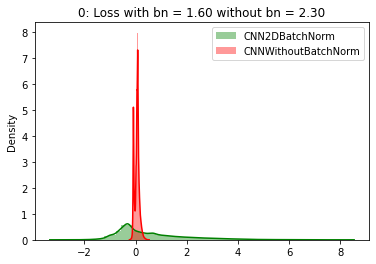

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


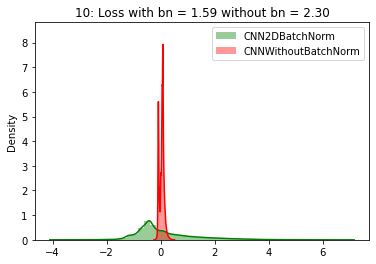

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


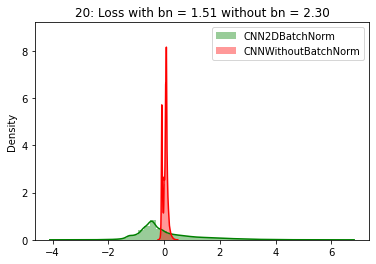

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


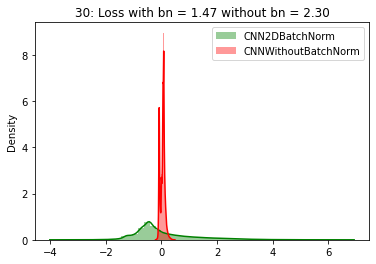

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


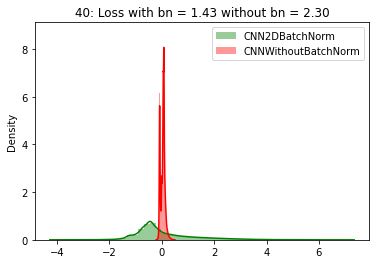

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


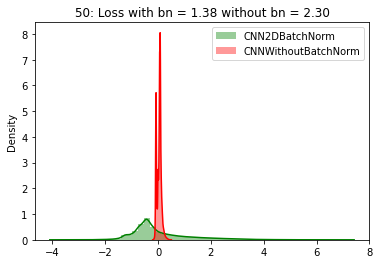

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


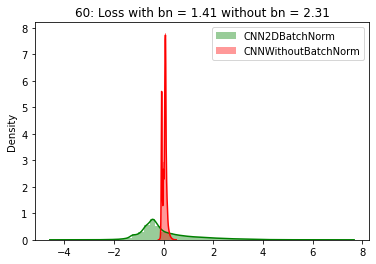

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


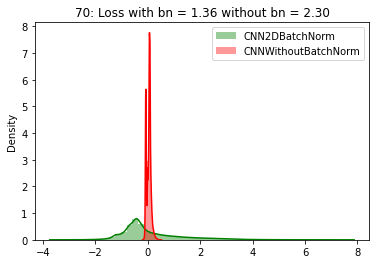

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


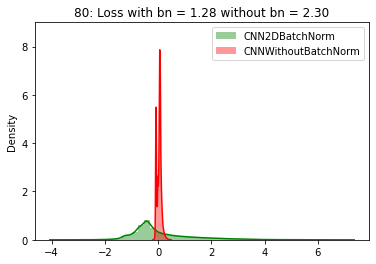

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


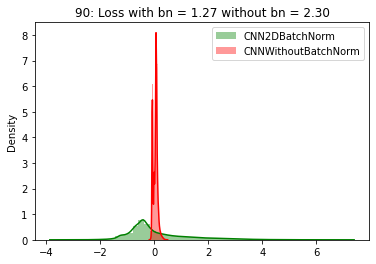

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


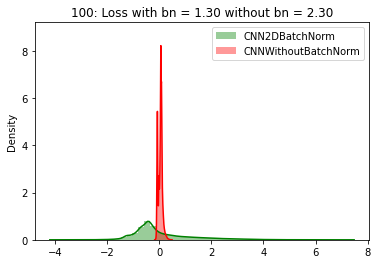

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


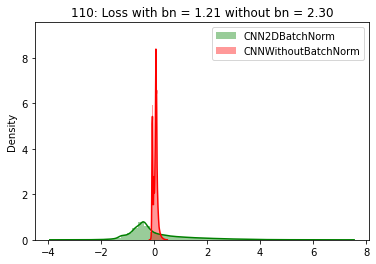

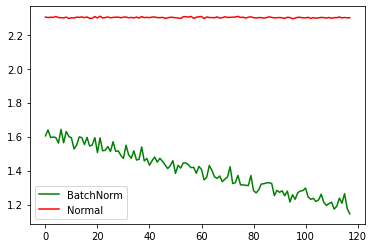

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


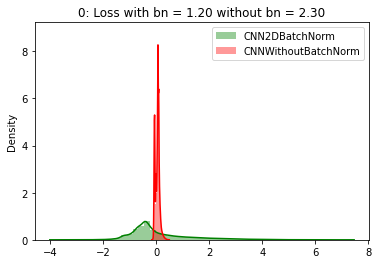

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


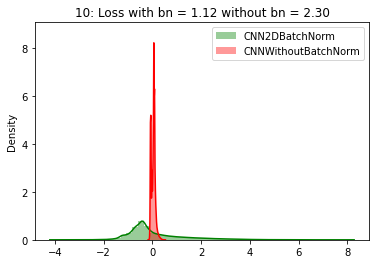

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


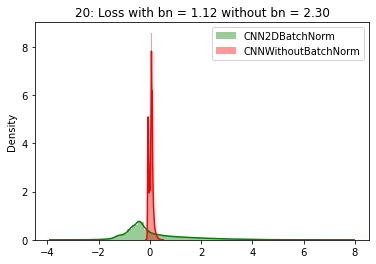

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


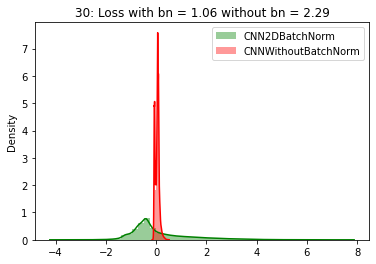

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


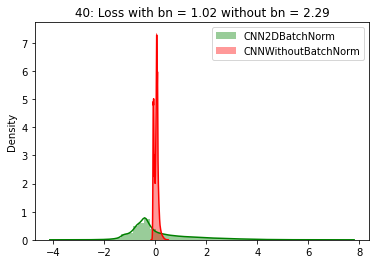

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


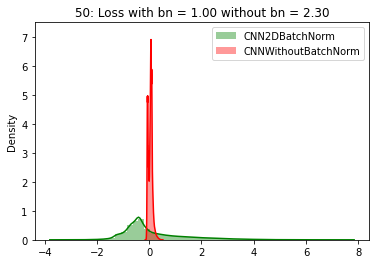

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [ ]:
loss_cnn_bn = []
loss_cnn_wbn = []
max_epochs = 2
for epoch in range(max_epochs):
  for i,data in enumerate(trainloader_cnn,0):
    input, label = data

    # Training with batch norm
    opt_cnn_bn.zero_grad()
    output = cnn_bn_model(input)
    loss_cnn = loss_fn(output,label)
    loss_cnn.backward()
    opt_cnn_bn.step()
    loss_cnn_bn.append(loss_cnn.item())

    #Training without batch norm
    opt_cnn_wbn.zero_grad()
    output_wbn = cnn_wbn_model(input)
    loss_wbn = loss_fn(output_wbn,label)
    loss_wbn.backward()
    opt_cnn_wbn.step()
    loss_cnn_wbn.append(loss_wbn.item())

    if i % 10 == 0:
      cnn_bn_model.eval()
      cnn_wbn_model.eval()
      a = cnn_bn_model.features[0](input)
      a = cnn_bn_model.features[1](a)
      a = cnn_bn_model.features[2](a)
      a = cnn_bn_model.features[3](a)
      a = cnn_bn_model.features[4](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a, kde=True, color='g', label='CNN2DBatchNorm')

      b = cnn_bn_model.features[0](input)
      b = cnn_bn_model.features[1](b)
      b = cnn_bn_model.features[2](b)
      b = cnn_bn_model.features[3](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b, kde=True, color='r', label='CNNWithoutBatchNorm')

      plt.title('%d: Loss with bn = %0.2f without bn = %0.2f' % (i, loss_cnn.item(),loss_wbn.item()))
      plt.legend()
      plt.show()
      plt.pause(0.5)
      cnn_bn_model.train()

  plt.plot(loss_cnn_bn,'g',label='BatchNorm')
  plt.plot(loss_cnn_wbn,'r',label='Normal')
  plt.legend()
  plt.show()


## Dropout

In [112]:
N = 50
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_train = X_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
Y_test = X_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

In [ ]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [ ]:
N_h = 100

model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

In [ ]:
max_epochs = 1000

for epoch in range(max_epochs):
    
    pred = model(X_train) # look at the entire data in a single shot
    loss = loss_fn(pred, Y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(X_train)
    loss_dropout = loss_fn(pred_dropout, Y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()
    
    
    if epoch % 50 == 0:
        
        model.eval()
        model_dropout.eval()
        
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, Y_test)
        
        test_pred_dropout = model_dropout(X_test)
        test_loss_dropout = loss_fn(test_pred_dropout, Y_test)
        
        plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='normal')
        plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        
        plt.legend()

        model.train()
        model_dropout.train()
        
        plt.pause(0.05)

## Exercises

1. Try out BatchNorm2d with MNIST dataset on a CNN
2. Try Dropout on a CNN with CIFAR10
3. Think of how to create a dataset which can suffer from large batch variation and/or overfitting
4. Try out BatchNorm and Dropout networks for such dataset